In [1]:
# Francisco Dominguez Mateos
# 02/09/2020
# Siamese network
# References: Dimensionality Reduction by Learning an Invariant Mapping
#    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
#Something is wrong, it dones't work as it should.
#12/09/2020 the base_net was too little

In [2]:
import time
import random as pyrandom
import numpy as onp

import jax.numpy as np
from jax import lax, grad, jit, vmap, value_and_grad
from jax import random
# Import some additional JAX and dataloader helpers
from jax.scipy.special import logsumexp
from jax.experimental import optimizers
from jax.experimental import stax
from jax.experimental.stax import (BatchNorm, Conv, Dense, Flatten,
                                   Relu, LogSoftmax,parallel)
import matplotlib.pyplot as plt

In [3]:
from tensorflow.keras.datasets import mnist

In [4]:
# Generate key which is used to generate random numbers
rng = random.PRNGKey(1)

In [5]:
#Shared params test. It seems to work
def f(x):
    return x*x
def l(x):
    return f(x)+f(x)
lg=grad(l)
print(l(3.0))
print(lg(3.0))

18.0
12.0


In [6]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1.0
    square_pred = np.square(y_pred)
    #square_pred = K.maximum(y_pred-margin, 0) #y_pred #K.square(y_pred)
    margin_square = np.square(np.maximum(margin - y_pred, 0.0))
    tcost=y_true * square_pred
    fcost=(1.0 - y_true) * margin_square
    return np.mean(tcost + fcost)


In [7]:
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for m in range(1):
        for d in range(num_classes):
            for i in range(n):
                ridx=pyrandom.randrange(1,n)
                idx=(i+ridx)%n
                z1, z2 = digit_indices[d][i], digit_indices[d][idx]
                pairs += [[x[z1], x[z2]]]
                inc = pyrandom.randrange(1, num_classes)
                dn = (d + inc) % num_classes
                z1, z2 = digit_indices[d][i], digit_indices[dn][i]
                pairs += [[x[z1], x[z2]]]
                labels += [1.0, 0.0]
    return onp.expand_dims(onp.array(pairs).astype("float32"),axis=-1), onp.array(labels).astype("float32")

In [8]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train  = x_train.astype('float32')
x_test   = x_test.astype ('float32')
y_train  = y_train.astype("float32")
y_test   = y_test.astype ("float32")
x_train /= 255
x_test  /= 255
input_shape = (x_train.shape[1],x_train.shape[1],1)
#input_shape = x_train.shape[1:]

print(input_shape)

(28, 28, 1)


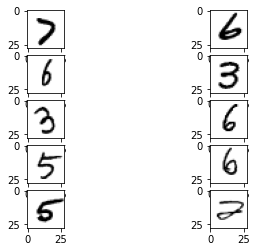

In [9]:
for i in range(5):
    plt.subplot(5,2,i*2+1)
    idx=pyrandom.randrange(0,x_train.shape[0])
    plt.imshow(x_train[idx], cmap="gray_r")
    plt.subplot(5,2,i*2+2)
    idx=pyrandom.randrange(0,x_train.shape[0])
    plt.imshow(x_train[idx], cmap="gray_r")
plt.show()

In [10]:
num_classes = 4
# create training+test positive and negative pairs
digit_indices = [onp.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [onp.where(y_test  == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)

In [11]:
print("tr_pairs=",tr_pairs.shape,"tr_y=",tr_y.shape,tr_y.dtype)
print("te_pairs=",te_pairs.shape,"te_y=",te_y.shape,te_y.dtype)
print(tr_pairs[:, 0].shape)

tr_pairs= (47376, 2, 28, 28, 1) tr_y= (47376,) float32
te_pairs= (7832, 2, 28, 28, 1) te_y= (7832,) float32
(47376, 28, 28, 1)


In [12]:
#Custom layer definitions

def ShareWeights(base_net):
    def init_fun(key,input_shape):
        init=base_net[0]
        nlayers=len(input_shape)
        output_shape,params=init(key,input_shape[0])
        return [output_shape]*nlayers,params
    def apply_fun(params,inputs,**kwargs):
        net=base_net[1]
        return [net(params,input) for input in inputs]
    return init_fun, apply_fun  

def Euclidean():
    def init_fun(key,input_shape):
        assert(len(input_shape)==2)
        output_shape=(input_shape[0][0],)
        return output_shape,()
    def apply_fun(params, inputs, **kwargs):
        assert(len(input_shape)==2)
        epsilon=1e-6
        x, y = inputs
        d=x-y
        sum_square = np.sum(np.square(d),axis=1)
        euclidean_d=np.sqrt(np.maximum(sum_square, epsilon))
        return euclidean_d
    return init_fun, apply_fun    

In [13]:
embedding_dim=2
d=dense(128)
# Conv seems to work with NHWC but it works with NCHW too
init_base, base_net = stax.serial(Conv(32, (5, 5), (1, 1), padding="SAME"),
                                 BatchNorm(), Relu,
                                 #Conv(32, (5, 5), (1, 1), padding="SAME"),
                                 #BatchNorm(), Relu,
                                 #Conv(10, (3, 3), (2, 2), padding="SAME"),
                                 #BatchNorm(), Relu,
                                 Conv(10, (3, 3), (2, 2), padding="SAME"), Relu,
                                 Flatten,
                                 Dense(128),
                                 Dense(128),
                                 Dense(embedding_dim))

init_siamese,siamese_net=stax.serial(
    ShareWeights((init_base, base_net)),
    Euclidean()
)

In [49]:
data_shape=(-1,2,28,28,1)
input_shape_base=(data_shape[0],*data_shape[2:])
input_shape=[input_shape_base]*2
print(input_shape)
output_shape,params=init_siamese(rng,input_shape)
print("ouput_shape=",output_shape)

[(-1, 28, 28, 1), (-1, 28, 28, 1)]
ouput_shape= (-1,)


In [15]:
# Make a batched version of the `net` function
#siamese_net = vmap(siamese_net , in_axes=(None, 0), out_axes=0)

In [16]:
input_test=[tr_pairs[:3,0],tr_pairs[:3,1]]
dist=siamese_net(params,input_test)
print(dist.shape,dist)

(3,) [2.0510101 2.4701345 1.4509218]


In [17]:
def contrastive_loss(params,inputs,label):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    dist_pred=siamese_net(params,inputs)
    #print("dist_pred=",dist_pred)
    margin_f = 1.0
    margin_t = 0.5
    push_t = dist_pred #pushing toward 0 aka minimizing :-)
    #push_t = np.maximum(dist_pred - margin_t, 0.0 )#pushing toward in  margin_t and then let free
    push_f = np.maximum(margin_f - dist_pred, 0.0 )#pushign toward out margin_f and then let free
    #print("push_f=",push_f)
    tcost  = label * push_t
    #print("tcost=",tcost)
    fcost  = (1.0 - label) * push_f
    #print("fcost=",fcost)
    cost   = tcost + fcost
    #print("cost =",cost)
    return np.mean(cost)

In [18]:
label_test=np.array([0]*3)
l=contrastive_loss(params,input_test,label_test)
print(l.shape,l)

() 0.0


In [19]:
def compute_accuracy(params,inputs,label):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    dist_pred=siamese_net(params,inputs)
    pred = dist_pred.ravel() < 0.5
    return np.mean(label == pred)

In [20]:
label_test=np.array([0]*3)
a=compute_accuracy(params,input_test,label_test)
print(a.shape,a)

() 1.0


In [51]:
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

In [52]:
def getBatch(x,y,i,batch_size):
    bx=[x[j][i*batch_size:i*batch_size+batch_size] for j in range(len(x))]
    by=    y[i*batch_size:i*batch_size+batch_size]
    return bx,by

In [23]:
batch_test=getBatch(input_test,label_test,0,3)
print(batch_test[0][0].shape,batch_test[0][1].shape,batch_test[1].shape)

(3, 28, 28, 1) (3, 28, 28, 1) (3,)


In [24]:
@jit
def update(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(contrastive_loss)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

In [25]:
params,opt_state,value=update(params,batch_test[0],batch_test[1],opt_state)
print(value)

0.0


In [26]:
def fit(opt_state,x,t,batch_size=100,epochs=1,validation_data=None):
    num_complete_batches, leftover = divmod(x[0].shape[0], batch_size)
    num_batches = num_complete_batches + bool(leftover)
    # Initialize placeholder for loggin
    log_acc_train, log_acc_test, train_loss = [], [], []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Get initial accuracy after random init
    test_acc  = compute_accuracy(params, validation_data[0],validation_data[1])
    train_acc = compute_accuracy(params, *getBatch(x,t,0,batch_size))
    log_acc_train.append(train_acc)
    log_acc_test.append(test_acc)

    # Loop over the training epochs
    for epoch in range(epochs):
        start_time = time.time()
        for ib in range(num_batches):
            bx,by=getBatch(x,t,ib,batch_size)
            params, opt_state, loss = update(params, bx, by, opt_state)
            train_loss.append(loss)

        epoch_time = time.time() - start_time
        test_acc  = compute_accuracy(params, validation_data[0],validation_data[1])
        test_loss = contrastive_loss(params, validation_data[0],validation_data[1])
        train_acc = compute_accuracy(params, *getBatch(x,t,0,batch_size))
        log_acc_train.append(train_acc)
        log_acc_test.append(test_acc)
        print("Epoch {} | T: {:0.2f} | Loss {:0.4f} | Train A: {:0.4f} | Loss {:0.4f} | Test A: {:0.4f}".format(epoch+1, epoch_time,
                                                                    loss,train_acc, test_loss, test_acc))
    return opt_state,train_loss, log_acc_train, log_acc_test

In [27]:
validation_data=((te_pairs[:,0],te_pairs[:,1]), te_y)
data=[tr_pairs[:,0],tr_pairs[:,1]]
labels=tr_y

In [59]:
batch_size=200
epochs=100
opt_state,train_loss,log_acc_train,log_acc_test=fit(opt_state,data,labels,batch_size,epochs,validation_data)

Epoch 1 | T: 1.92 | Loss 0.0431 | Train A: 1.0000 | Loss 0.1557 | Test A: 0.9236
Epoch 2 | T: 1.93 | Loss 0.0424 | Train A: 1.0000 | Loss 0.1553 | Test A: 0.9230
Epoch 3 | T: 1.93 | Loss 0.0437 | Train A: 1.0000 | Loss 0.1551 | Test A: 0.9233
Epoch 4 | T: 1.94 | Loss 0.0440 | Train A: 1.0000 | Loss 0.1551 | Test A: 0.9238
Epoch 5 | T: 1.95 | Loss 0.0431 | Train A: 1.0000 | Loss 0.1540 | Test A: 0.9235
Epoch 6 | T: 1.93 | Loss 0.0433 | Train A: 1.0000 | Loss 0.1542 | Test A: 0.9239
Epoch 7 | T: 1.94 | Loss 0.0436 | Train A: 1.0000 | Loss 0.1534 | Test A: 0.9238
Epoch 8 | T: 1.94 | Loss 0.0434 | Train A: 1.0000 | Loss 0.1539 | Test A: 0.9238
Epoch 9 | T: 1.93 | Loss 0.0429 | Train A: 1.0000 | Loss 0.1536 | Test A: 0.9226
Epoch 10 | T: 1.95 | Loss 0.0423 | Train A: 1.0000 | Loss 0.1542 | Test A: 0.9219
Epoch 11 | T: 2.05 | Loss 0.0414 | Train A: 1.0000 | Loss 0.1530 | Test A: 0.9217
Epoch 12 | T: 2.08 | Loss 0.0418 | Train A: 1.0000 | Loss 0.1515 | Test A: 0.9233
Epoch 13 | T: 2.11 | Loss

In [60]:
params=get_params(opt_state)
test_acc  = compute_accuracy(params, validation_data[0],validation_data[1])
print(test_acc)

0.9351379


In [47]:
l=contrastive_loss(params,validation_data[0],validation_data[1])
print(l.shape,l)

() 0.1827312


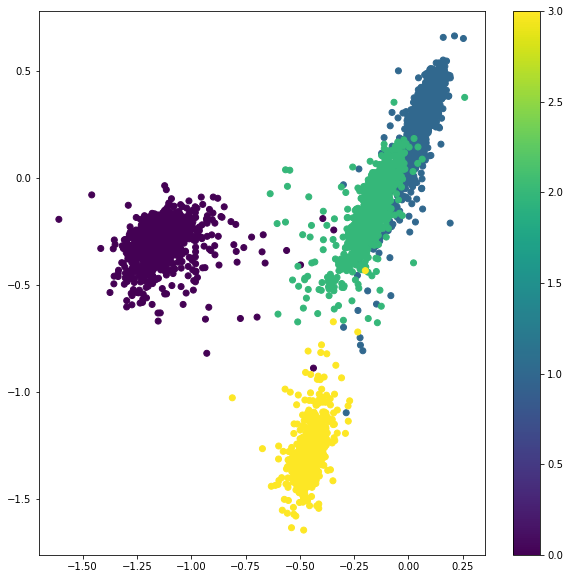

In [61]:
# display a 2D plot of the digit classes in the latent space
base_params=params[0]
idxs=onp.hstack((digit_indices[0],digit_indices[1],digit_indices[2],digit_indices[3]))
ex_test=np.expand_dims(x_test[idxs],axis=-1)
x_test_encoded = base_net(base_params,ex_test)
plt.figure(figsize=(10, 10))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test[idxs])
plt.colorbar()
plt.show()